In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'traffic-prediction-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1169027%2F1958513%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240428%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240428T164421Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D206320d1f8165249d546365865d8e9e832d098f6ff8beda85f005f8b62e6e600c717166da94260a6a35b272dd1cac4a112c105b468bab20ed8d057b45f008b5d6cfeba3239a11f4377adaeb58307082d12e90bf329787e8c76e45e8d8b46ad3344117cc9beb369ff0b5acfd698aa37f914b0707db6093f84d4f2eaa73aadbf19e14fd45e6d30bba57b4c7fee36d28ac5098ab672cc60ce0ac2760075b2a1355b291e5fed7083a6ac4ad3d0ca8b2bd9c5e710539bff6b332dd5712b62cc928bfc36115791685a73a0e52f4843927fcaa35b9acaed84757d06ca4a443f6cb3e500ff45335b54c89ed7a35e0ab587685353127b11e29935b41c7664cc8d72f42932'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 283801 bytes downloaded
Downloaded and uncompressed: traffic-prediction-dataset
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import layers, Sequential, callbacks
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD, Adam
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers.schedules import ExponentialDecay

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/traffic-prediction-dataset/traffic.csv


In [3]:
data=pd.read_csv("/kaggle/input/traffic-prediction-dataset/traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [4]:
data['DateTime']=pd.to_datetime(data['DateTime'])

data["Year"]=data['DateTime'].dt.year

data["Month"]=data['DateTime'].dt.month

data["Date_no"]=data['DateTime'].dt.day

data["Hour"]=data['DateTime'].dt.hour

data["Day"]= data['DateTime'].dt.strftime("%A")
data

,DateTime,Junction,Vehicles,ID,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,4,Sunday
...,...,...,...,...,...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194,2017,6,30,19,Friday
48116,2017-06-30 20:00:00,4,30,20170630204,2017,6,30,20,Friday
48117,2017-06-30 21:00:00,4,16,20170630214,2017,6,30,21,Friday
48118,2017-06-30 22:00:00,4,22,20170630224,2017,6,30,22,Friday


<Axes: xlabel='Date_no', ylabel='Vehicles'>

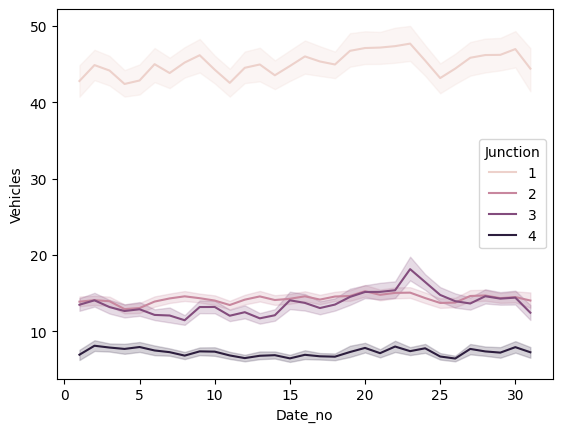

In [5]:
sns.lineplot(x=data['Date_no'],y="Vehicles",data=data,hue='Junction')

In [6]:
data = data[(data['Junction'] == 1)]
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [7]:
df_N, av, std = Normalize(data, "Vehicles")
Diff = Difference(df_N, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N = df_N[24*7:]
df_N.columns = ["Norm"]
df_N["Diff"]= Diff
df = df_N["Diff"].dropna()
df = df.to_frame()
df.head()

<ipython-input-7-e489de12f393>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_N["Diff"]= Diff


,Diff
168,-0.086925
169,0.130387
170,0.043462
171,0.043462
172,0.043462


In [8]:
df.shape

(14424, 1)

In [9]:
def Split_data(df):
    training_size = int(len(df)*0.80)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test

df_train, df_test = Split_data(df)

In [10]:
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

X_train, y_train = TnF(df_train)
X_test, y_test = TnF(df_test)
X_train, X_test = FeatureFixShape(X_train, X_test)

In [11]:
X_train, X_test = FeatureFixShape(X_train, X_test)
from sklearn.metrics import mean_absolute_error

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)

def MLP_model(X_Train, y_Train, X_Test, y_Test):
    X_Train = np.squeeze(X_Train)  # This line removes the unnecessary dimension
    X_Test = np.squeeze(X_Test)    # Do the same for the test data
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=X_Train.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='relu', input_dim=X_Train.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train, y_Train, validation_data=(X_test, y_test), epochs=50, batch_size=120, callbacks=[early_stopping])
    pred_MLP = model.predict(X_Test)
    return pred_MLP

In [12]:
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

def MAE_Value(test,predicted):
    mae = mean_absolute_error(test, predicted)
    print("The MAE is {}.".format(mae))
    return mae

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5))
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted,label="Predicted Values")
    plt.title("Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

In [13]:
Pred_MLP = MLP_model(X_train,y_train,X_test, y_test)

Epoch 1/50
96/96 [==============================] - 1s 5ms/step - loss: 0.0789 - val_loss: 0.0681
Epoch 2/50
96/96 [==============================] - 0s 3ms/step - loss: 0.0586 - val_loss: 0.0633
Epoch 3/50
96/96 [==============================] - 0s 3ms/step - loss: 0.0536 - val_loss: 0.0603
Epoch 4/50
96/96 [==============================] - 0s 3ms/step - loss: 0.0518 - val_loss: 0.0599
Epoch 5/50
96/96 [==============================] - 0s 3ms/step - loss: 0.0508 - val_loss: 0.0591
Epoch 6/50
96/96 [==============================] - 0s 3ms/step - loss: 0.0498 - val_loss: 0.0584
Epoch 7/50
96/96 [==============================] - 0s 3ms/step - loss: 0.0485 - val_loss: 0.0578
Epoch 8/50
96/96 [==============================] - 0s 3ms/step - loss: 0.0488 - val_loss: 0.0580
Epoch 9/50
96/96 [==============================] - 0s 3ms/step - loss: 0.0474 - val_loss: 0.0574
Epoch 10/50
96/96 [==============================] - 0s 3ms/step - loss: 0.0474 - val_loss: 0.0573
Epoch 11/50
96/96 [

The root mean squared error is 0.23606013472548254.
The MAE is 0.1700311455392691.


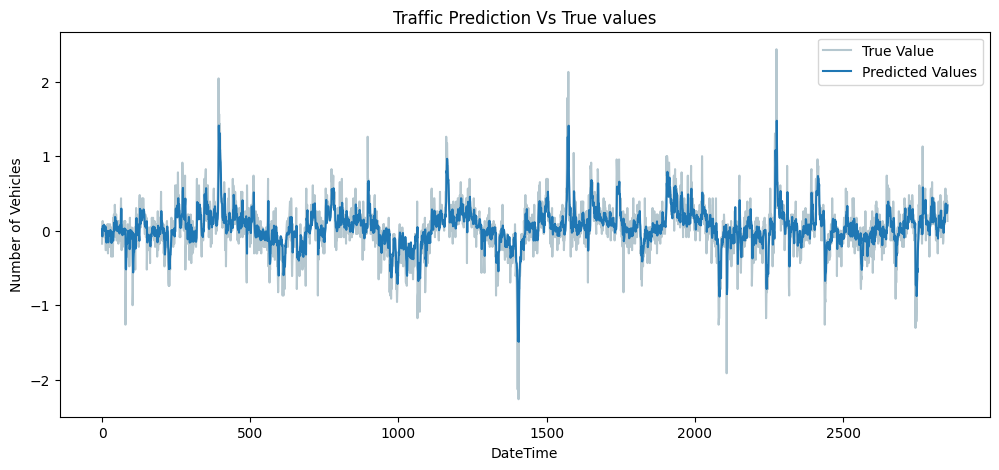

In [14]:
colors = ["#6D91A1","#74B3CE1","#536D7A","#3E535B"]
RMSE_MLP = RMSE_Value(y_test, Pred_MLP)
MAE_MLP = MAE_Value(y_test, Pred_MLP)
PredictionsPlot(y_test, Pred_MLP, 0)

In [15]:
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed

def Sub_Plots(df_1, df_2,title,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True)
    fig.suptitle(title)

    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[m])
    axes[0].set(ylabel ="Prediction")

    pl_2=sns.lineplot(ax=axes[1],data=df_2["Vehicles"],color="#3E535B")
    axes[1].set(ylabel ="Original")

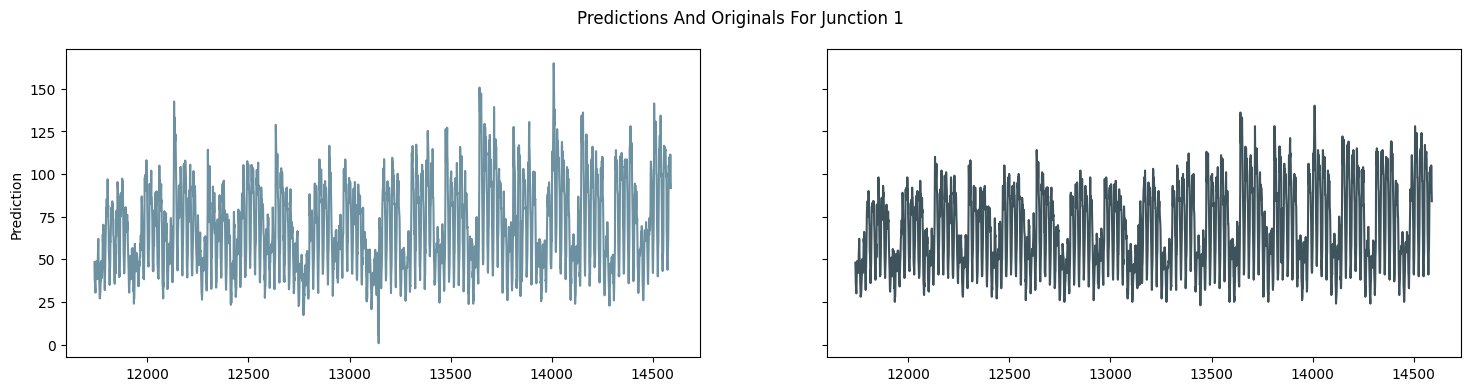

In [16]:
recover = df_N.Norm[-2854:-1].to_frame()
recover["Pred"]= globals()[f"Pred_MLP"]
Transform_reverssed = inverse_difference(recover.Norm, recover.Pred).to_frame()
Transform_reverssed.columns = ["Pred_Normed"]
Final_Pred = (Transform_reverssed.values* std) + av
Transform_reverssed["Pred_Final"] = Final_Pred
Sub_Plots(Transform_reverssed["Pred_Final"], data[-2854:-1],"Predictions And Originals For Junction 1", 0)

In [17]:
def GRU_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
    #callback delta 0.01 may interrupt the learning.

    #The GRU model
    model = Sequential()
    model.add(GRU(units=100, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=20, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU

In [18]:
def LSTM_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)

    #The LSTM model
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=20, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_LSTM = model.predict(X_Test)
    return pred_LSTM

In [19]:
Pred_GRU = GRU_model(X_train,y_train,X_test,y_test)

Epoch 1/50
96/96 [==============================] - 13s 84ms/step - loss: 0.0538 - val_loss: 0.0615
Epoch 2/50
96/96 [==============================] - 8s 85ms/step - loss: 0.0481 - val_loss: 0.0601
Epoch 3/50
96/96 [==============================] - 8s 88ms/step - loss: 0.0474 - val_loss: 0.0592
Epoch 4/50
96/96 [==============================] - 8s 82ms/step - loss: 0.0468 - val_loss: 0.0585
Epoch 5/50
96/96 [==============================] - 9s 94ms/step - loss: 0.0466 - val_loss: 0.0581
Epoch 6/50
96/96 [==============================] - 10s 106ms/step - loss: 0.0464 - val_loss: 0.0587
Epoch 7/50
96/96 [==============================] - 8s 87ms/step - loss: 0.0455 - val_loss: 0.0570
Epoch 8/50
96/96 [==============================] - 9s 97ms/step - loss: 0.0457 - val_loss: 0.0567
Epoch 9/50
96/96 [==============================] - 10s 106ms/step - loss: 0.0455 - val_loss: 0.0568
Epoch 10/50
96/96 [==============================] - 10s 109ms/step - loss: 0.0451 - val_loss: 0.0563
Ep

The root mean squared error is 0.23664335365690098.
The MAE is 0.17137464269660532.


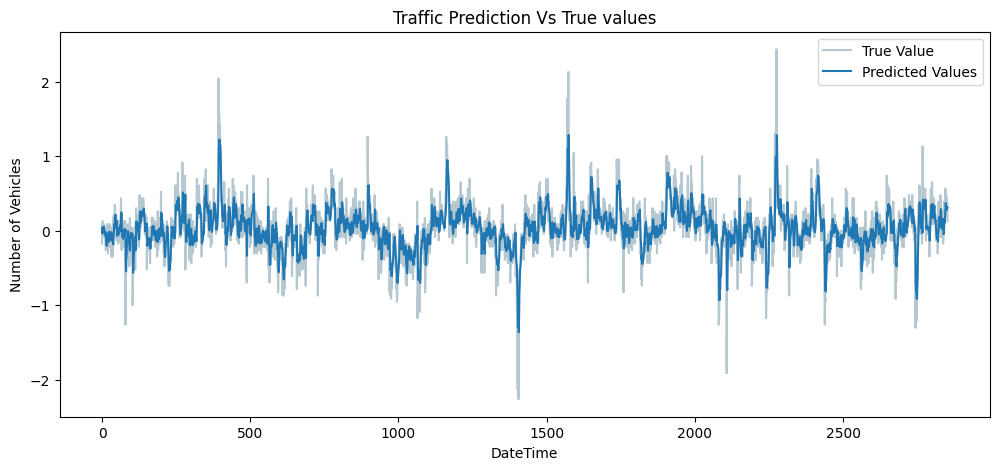

In [20]:
RMSE_GRU = RMSE_Value(y_test, Pred_GRU)
MAE_GRU = MAE_Value(y_test, Pred_GRU)
PredictionsPlot(y_test, Pred_GRU, 0)

In [21]:
Pred_LSTM = LSTM_model(X_train,y_train,X_test, y_test)

Epoch 1/50
96/96 [==============================] - 14s 110ms/step - loss: 0.0668 - val_loss: 0.0811
Epoch 2/50
96/96 [==============================] - 8s 86ms/step - loss: 0.0591 - val_loss: 0.0772
Epoch 3/50
96/96 [==============================] - 9s 97ms/step - loss: 0.0571 - val_loss: 0.0745
Epoch 4/50
96/96 [==============================] - 9s 96ms/step - loss: 0.0563 - val_loss: 0.0728
Epoch 5/50
96/96 [==============================] - 9s 91ms/step - loss: 0.0544 - val_loss: 0.0710
Epoch 6/50
96/96 [==============================] - 9s 94ms/step - loss: 0.0533 - val_loss: 0.0696
Epoch 7/50
96/96 [==============================] - 10s 109ms/step - loss: 0.0530 - val_loss: 0.0682
Epoch 8/50
96/96 [==============================] - 9s 99ms/step - loss: 0.0520 - val_loss: 0.0669
Epoch 9/50
96/96 [==============================] - 8s 84ms/step - loss: 0.0515 - val_loss: 0.0658
Epoch 10/50
96/96 [==============================] - 9s 97ms/step - loss: 0.0509 - val_loss: 0.0652
Epoch

The root mean squared error is 0.23829798668521476.
The MAE is 0.17209412381495343.


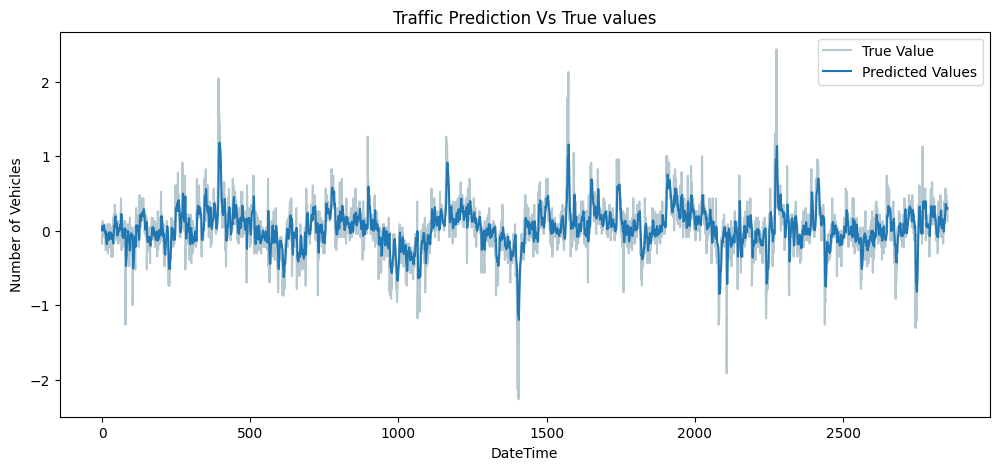

In [22]:
RMSE_LSTM = RMSE_Value(y_test, Pred_LSTM)
MAE_LSTM = MAE_Value(y_test, Pred_LSTM)
PredictionsPlot(y_test, Pred_LSTM, 0)